In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=20

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [6]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

Pepper__bell___Bacterial_spot: 997
Pepper__bell___healthy: 1478
Potato___Early_blight: 1000
Potato___Late_blight: 1000
Potato___healthy: 152
Tomato_Bacterial_spot: 2127
Tomato_Early_blight: 1000
Tomato_Late_blight: 1909
Tomato_Leaf_Mold: 952
Tomato_Septoria_leaf_spot: 1771
Tomato_Spider_mites_Two_spotted_spider_mite: 1676
Tomato__Target_Spot: 1404
Tomato__Tomato_YellowLeaf__Curl_Virus: 3208
Tomato__Tomato_mosaic_virus: 373
Tomato_healthy: 1591


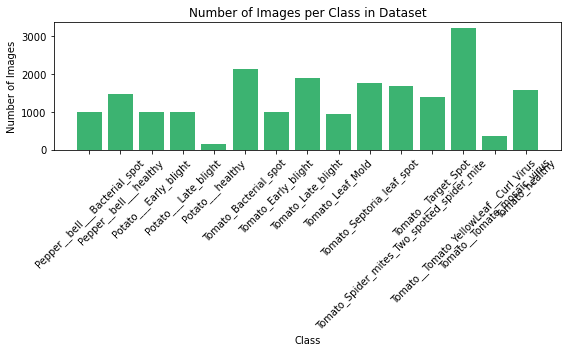

In [7]:
class_counts = np.zeros(len(class_names), dtype=int)

for images, labels in dataset:
    for label in labels.numpy():
        class_counts[label] += 1

for name, count in zip(class_names, class_counts):
    print(f"{name}: {count}")

plt.figure(figsize=(8, 5))
plt.bar(class_names, class_counts, color='mediumseagreen')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size=ds.take(train_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [10]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
516/516 [==============================] - 883s 2s/step - loss: 2.1076 - accuracy: 0.3120 - val_loss: 1.5655 - val_accuracy: 0.4561
Epoch 2/20
516/516 [==============================] - 750s 1s/step - loss: 1.3429 - accuracy: 0.5493 - val_loss: 1.1453 - val_accuracy: 0.6177
Epoch 3/20
516/516 [==============================] - 723s 1s/step - loss: 0.8996 - accuracy: 0.6865 - val_loss: 0.7395 - val_accuracy: 0.7339
Epoch 4/20
516/516 [==============================] - 731s 1s/step - loss: 0.7459 - accuracy: 0.7349 - val_loss: 0.6759 - val_accuracy: 0.7603
Epoch 5/20
516/516 [==============================] - 739s 1s/step - loss: 0.6095 - accuracy: 0.7872 - val_loss: 0.7766 - val_accuracy: 0.7344
Epoch 6/20
516/516 [==============================] - 722s 1s/step - loss: 0.5132 - accuracy: 0.8212 - val_loss: 0.6360 - val_accuracy: 0.7773
Epoch 7/20
516/516 [==============================] - 722s 1s/step - loss: 0.4773 - accuracy: 0.8332 - val_loss: 0.4568 - val_accuracy: 0.8379

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

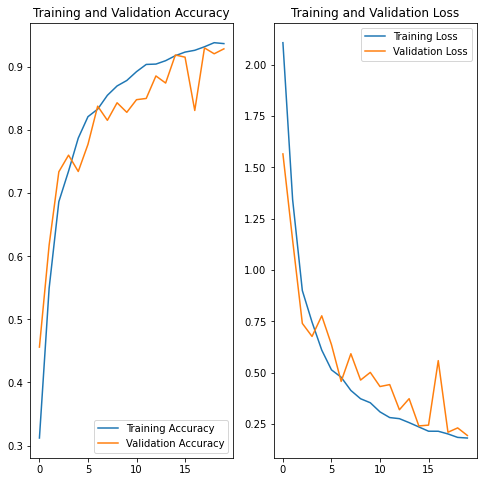

In [18]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

65/65 [==============================] - 13s 198ms/step


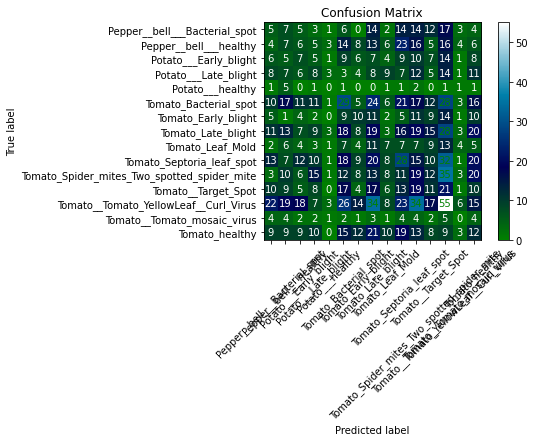

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_labels = np.concatenate([labels.numpy() for _, labels in test_ds])

y_pred_probs = model.predict(test_ds)
predicted_labels = np.argmax(y_pred_probs, axis=1)

test_class_labels = dataset.class_names

#test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=test_class_labels)
disp.plot(cmap='ocean', xticks_rotation=45)
disp.ax_.set_title("Confusion Matrix")
plt.show()

65/65 [==============================] - 13s 196ms/step


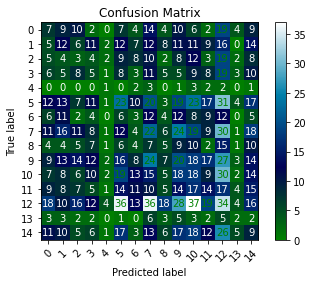

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_labels = np.concatenate([labels.numpy() for _, labels in test_ds])

y_pred_probs = model.predict(test_ds)
predicted_labels = np.argmax(y_pred_probs, axis=1)

#test_class_labels = test_ds.dataset.class_names

#test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)#, #display_labels=test_class_labels#)
disp.plot(cmap='ocean', xticks_rotation=45)
disp.ax_.set_title("Confusion Matrix")
plt.show()

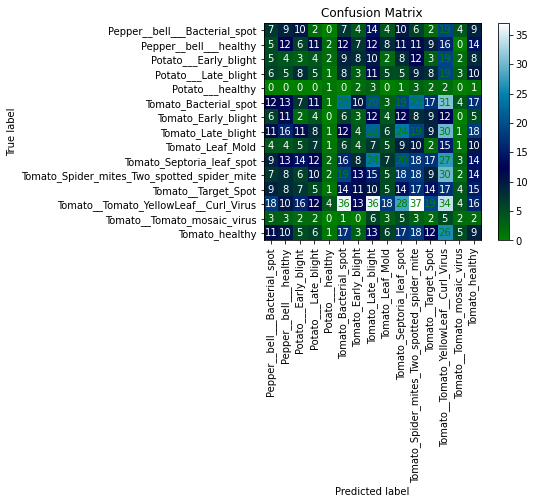

In [41]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='ocean', xticks_rotation=90)
disp.ax_.set_title("Confusion Matrix")
plt.show()

In [38]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence